In [1]:
!python --version

Python 3.9.18


In [2]:
import torch
torch.__version__

C:\Users\navee\anaconda3\envs\DL_projects\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.12.1'

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:

# train_dir = 'E:/Deep learning/Project/OTHER_DATA/2/archive/food-101/food-101/train/'
# test_dir = 'E:/Deep learning/Project/OTHER_DATA/2/archive/food-101/food-101/test/'


# train_dir = 'E:/Deep learning/Project/OTHER_DATA/2/archive/food-101/food-101/subset_train/'
# test_dir = 'E:/Deep learning/Project/OTHER_DATA/2/archive/food-101/food-101/subset_test/'

# train_dir='E:/Deep learning/Project/OTHER_DATA/2/archive/food-101/food-101/subset_train_v2/'
# test_dir = 'E:/Deep learning/Project/OTHER_DATA/2/archive/food-101/food-101/subset_test_v2/'

train_dir = 'E:/Deep learning/Project/OTHER_DATA/2/archive/food-101/food-101/sub_v2/subset_train_v2/'
test_dir = 'E:/Deep learning/Project/OTHER_DATA/2/archive/food-101/food-101/sub_v2/subset_test_v2/'

# Create Datasets and DataLoaders

In [6]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# NUM_WORKERS = os.cpu_count()
NUM_WORKERS = 0

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

 
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  
  class_names = train_data.classes

 
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [7]:

IMG_SIZE = 224


manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [8]:

BATCH_SIZE = 8 



import torchvision.transforms as transforms


data_augmentation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.15, saturation=0.1, hue=0.1),
    transforms.RandomRotation(25),  # Randomly rotate the image up to 20 degrees
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # Apply random affine transformations
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Apply random perspective transformation
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
#     transforms.Normalize(mean=[0.556, 0.447, 0.335], std=[0.231, 0.242, 0.238])  # Normalize the image
])

# data_augmentation_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor()  # Convert the image to a PyTorch tensor

# ])


manual_transforms = transforms.Compose([
    # Your manual transforms (resize, center-crop, etc.) here
    data_augmentation_transforms
])



train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1ef0553bf70>,
 ['garlic_bread', 'hot_dog', 'ice_cream', 'omelette', 'pizza'])

torch.Size([3, 224, 224]) tensor(0)


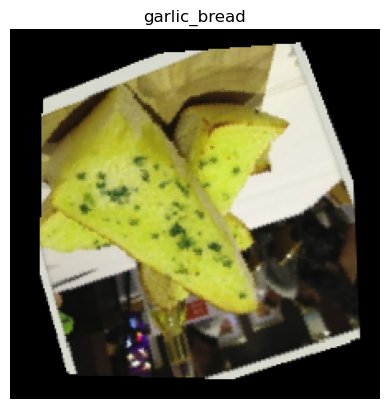

In [9]:

image_batch, label_batch = next(iter(train_dataloader))


image, label = image_batch[0], label_batch[0]


print(image.shape, label)


plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions  [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

# Step 1 

#### Tasks:

1- turn an image into patches

2- flatten the patch feature maps into a single dimension

3- Convert the output into Desried output (flattened 2D patches): (196, 768) -> N×(P2⋅C)       #Current shape: (1, 768, 196)

In [10]:

class PatchEmbedding(nn.Module):


    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
       
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

    
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)


    def forward(self, x):
        
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        
       
        return x_flattened.permute(0, 2, 1) 

# PatchEmbedding layer ready

In [11]:

patch_size =16


def set_seeds(seed: int=42):

    torch.manual_seed(seed)

    torch.cuda.manual_seed(seed)
    
    
    
set_seeds()


patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)


print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) 
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [12]:



print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         ...,
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [13]:


set_seeds()


patch_size = 16


print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]


x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")


patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)


patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")




batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")


patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")


number_of_patches = int((height * width) / patch_size**2)



import numpy as np
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result

position_embedding = nn.Parameter(get_positional_embeddings(number_of_patches+1,embedding_dimension),requires_grad=True)



patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

print(patch_embedding_class_token) 
print(patch_and_position_embedding)


Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         ...,
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033]]],
       grad_fn=<CatBackward0>)
tensor([[[ 1.0000,  2.0000,  1.0000,  ...,  2.0000,  1.0000,  2.0000],
         [ 0.8227,  0.5289,  0.7973,  ...,  1.0105, -0.0032,  1.0033],
         [ 0.8905, -0.4275,  0.8969, 

In [14]:

class MultiheadSelfAttentionBlock(nn.Module):

    def __init__(self,
                 embedding_dim:int=768, 
                 num_heads:int=12, 
                 attn_dropout:float=0): 
        super().__init__()
        

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
   
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) 
        

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) 
        return attn_output

# MLP Block

In [15]:

class MLPBlock(nn.Module):

    def __init__(self,
                 embedding_dim:int=768, 
                 mlp_size:int=3072, 
                 dropout:float=0.1): 
        super().__init__()
        

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), 
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, 
                      out_features=embedding_dim), 
            nn.Dropout(p=dropout) 
        )
    

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

# Transformer Encoder 

In [16]:

class TransformerEncoderBlock(nn.Module):

    def __init__(self,
                 embedding_dim:int=768, 
                 num_heads:int=12, 
                 mlp_size:int=3072, 
                 mlp_dropout:float=0.1, 
                 attn_dropout:float=0): 
        super().__init__()


        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
 
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        

    def forward(self, x):
        
      
        x =  self.msa_block(x) + x 
        
        
        x = self.mlp_block(x) + x 
        
        return x
    


#### Transformer Encoder block created!

In [17]:


transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

# Let's build a vision transformer

In [18]:

class ViT(nn.Module):

    def __init__(self,
                 img_size:int=224, 
                 in_channels:int=3, 
                 patch_size:int=16, 
                 num_transformer_layers:int=12, 
                 embedding_dim:int= 768, 
                 mlp_size:int=3072, 
                 num_heads:int=12, 
                 attn_dropout:float=0, 
                 mlp_dropout:float=0.1, 
                 embedding_dropout:float=0.1, 
                 num_classes:int=1000): 
        super().__init__() 
        
      
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
       
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
        self.softmax=torch.nn.Softmax()
    
   
    def forward(self, x):
        
        
        batch_size = x.shape[0]
        
        
        class_token = self.class_embedding.expand(batch_size, -1, -1) 
        
      
        x = self.patch_embedding(x)

        
        x = torch.cat((class_token, x), dim=1)

     
        x = self.position_embedding + x

    
        x = self.embedding_dropout(x)

  
        x = self.transformer_encoder(x)

     
        x = self.classifier(x[:, 0]) 
        
        
#         x=self.softmax(x)

        return x       

# Train Model

In [19]:

vit = ViT(num_classes=len(class_names))
vit.load_state_dict(torch.load('E:/Deep learning/Project/code_data/Image-Classification-Using-Vision-transformer-main/weights/overfitmiti_b2/9.pt'), strict=False)



<All keys matched successfully>

In [ ]:
from going_modular.going_modular import engine_sl
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.AdamW(params=vit.parameters(), 
                             lr=0.0001, 
                             betas=(0.9, 0.999), 
                             weight_decay=0.3) 
scheduler = CosineAnnealingLR(optimizer, T_max=10,eta_min=0.0001,verbose=True)



loss_fn = torch.nn.CrossEntropyLoss()


set_seeds()


results = engine_sl.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       scheduler = scheduler,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

Adjusting learning rate of group 0 to 1.0000e-04.


  0%|▏                                                                               | 1/600 [00:10<1:40:31, 10.07s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Training | Loss: 1.0057, Accuracy: 0.7500



  0%|▎                                                                               | 2/600 [00:16<1:16:46,  7.70s/it]

Adjusting learning rate of group 0 to 1.0000e-04.
Training | Loss: 0.9330, Accuracy: 0.7500


Our ViT model has come to life!

Results on our custom dataset don't look too good.

Lets plot the accuracy and loss curves

In [ ]:

from helper_functions import plot_loss_curves


plot_loss_curves(results)

In [ ]:
results.keys()

In [ ]:

plt.plot(range(len(results["learning_rates"])), results['learning_rates'], label="learning rate")
plt.title("lr")
plt.xlabel("Epochs")
plt.legend()

# Predictions

In [ ]:
import requests


from going_modular.going_modular.predictions import pred_and_plot_image


custom_image_path = "E:/Deep learning/Project/OTHER_DATA/2/archive/food-101/food-101/sub_v3/subset_test_v2/pizza/111051.jpg"


pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)